# Term Project: AlphaSignal Dual-Source Intelligence
## Group 9

---

### 1. System Architecture
The system follows a Microservices architecture orchestrated by Docker. It consists of three isolated containers communicating via a shared internal network.

**High-Level Architecture:**
* **Internet Sources** (NYT, NewsAPI) -> **ETL Container** (Python)
* **ETL Container** -> **Database Container** (MongoDB)
* **Database Container** -> **Dashboard Container** (Flask)
* **User** -> **Dashboard** (Browser)

### 2. ETL Process Flow
The "Extract-Transform-Load" pipeline runs indefinitely to ensure real-time data freshness.
1.  **Extract:** Fetch Stock Prices (Yahoo) + News (NYT/NewsAPI).
2.  **Transform:** Deduplicate URLs. Calculate Sentiment (TextBlob + Financial Dictionary).
3.  **Load:** Upsert clean data into MongoDB `news_data` collection.

### 3. Database Schema (NoSQL)
We utilized MongoDB for its schema-less flexibility.
* **Collection:** `news_data`
* **Key Fields:** `related_ticker` (Index), `source` (NYT/NewsAPI), `sentiment_score` (-1 to +1), `url` (Unique Key).

### 4. Quantification Methodology
How do we turn text into data?
* **Relevance:** Impact is determined by **Entity Linking** (searching specifically for "Apple Inc" vs just "Apple").
* **Metric:** We use a **Composite Score**:
    * **Base:** `TextBlob` Polarity.
    * **Boost:** Custom dictionary (+/- 0.15 for words like "Profit" or "Crash").

---

### Database Connection

In [9]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 1. CONNECT TO DATABASE
# We use port 27018 because that is the external port exposed in docker-compose
try:
    client = pymongo.MongoClient("mongodb://localhost:27018/")
    db = client["sentiment_db"]
    print("✅ SUCCESS: Connected to Docker MongoDB.")
except Exception as e:
    print(f"❌ ERROR: Ensure 'docker-compose up' is running. {e}")

# 2. DATA RANGE ANALYSIS
try:
    min_date_doc = db.news_data.find_one(sort=[("published_at", 1)])
    max_date_doc = db.news_data.find_one(sort=[("published_at", -1)])
    
    if min_date_doc and max_date_doc:
        print(f"\n📅 DATA COLLECTION RANGE:")
        print(f"• Start: {min_date_doc['published_at']}")
        print(f"• End:   {max_date_doc['published_at']}")
    else:
        print("⚠️ Not enough data to calculate range.")
except:
    print("⚠️ Date format error (waiting for fresh data).")


✅ SUCCESS: Connected to Docker MongoDB.

📅 DATA COLLECTION RANGE:
• Start: 2025-04-15T00:40:13Z
• End:   2025-12-02T23:13:26Z


### Analysis & Charts


✅ Data Volume: 91 analyzed articles.

--- SENTIMENT DIVERGENCE TABLE ---
  Ticker          Source  Sentiment Score  Article Count
0   AAPL  New York Times         0.088808             15
7   AAPL         NewsAPI         0.143250              9
5   NVDA  New York Times         0.003750             10
6   NVDA         NewsAPI         0.146856             10
1    SPY  New York Times        -0.024579             10
2    SPY         NewsAPI         0.157143             14
3   TSLA  New York Times         0.168006             14
4   TSLA         NewsAPI         0.171409              9


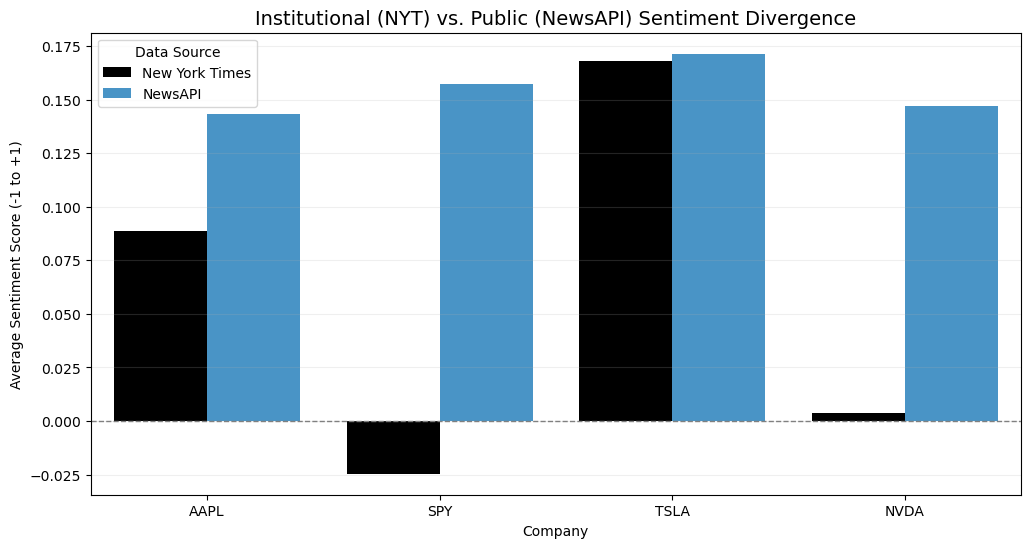

In [8]:
# 3. EXTRACT & AGGREGATE DATA
pipeline = [
    {
        "$group": {
            "_id": {"ticker": "$related_ticker", "source": "$source"},
            "avg_sentiment": {"$avg": "$sentiment_score"},
            "count": {"$sum": 1}
        }
    }
]

data = list(db.news_data.aggregate(pipeline))

clean_data = []
for row in data:
    clean_data.append({
        "Ticker": row["_id"]["ticker"],
        "Source": row["_id"]["source"],
        "Sentiment Score": row["avg_sentiment"],
        "Article Count": row["count"]
    })

df = pd.DataFrame(clean_data)

if not df.empty:
    print(f"\n✅ Data Volume: {df['Article Count'].sum()} analyzed articles.")
    print("\n--- SENTIMENT DIVERGENCE TABLE ---")
    print(df.sort_values(by="Ticker"))

    # 4. VISUALIZATION
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df, 
        x="Ticker", 
        y="Sentiment Score", 
        hue="Source", 
        palette={"New York Times": "black", "NewsAPI": "#3498db"}
    )
    
    plt.title("Institutional (NYT) vs. Public (NewsAPI) Sentiment Divergence", fontsize=14)
    plt.xlabel("Company")
    plt.ylabel("Average Sentiment Score (-1 to +1)")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.legend(title="Data Source")
    plt.grid(axis='y', alpha=0.2)
    plt.show()
else:
    print("⚠️ No data found yet. Please let the Docker dashboard run for 5 minutes.")